In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import xesmf as xe
from sklearn.linear_model import LinearRegression
import scipy.stats as ss
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def ols_map(x, y): 
    # OLS regression
    # regress along the leftmost axis
    N      = x.shape[0]
    x_mean = np.mean(x,axis=0)
    y_mean = np.mean(y,axis=0)
    
    x_centered = x - x_mean[np.newaxis,...]
    y_centered = y - y_mean[np.newaxis,...]
    
    cov_xy = np.sum(x_centered * y_centered, axis=0) / (N-1)
    var_x  = np.sum(x_centered ** 2, axis=0) / (N-1)
    var_y  = np.sum(y_centered ** 2, axis=0) / (N-1)
    
    r = cov_xy / var_x
    return r

In [3]:
with xr.open_dataset('/Users/yuanjenlin/Dropbox/Postdoc_CU/GFMIP/GFMIP_boundary_conditions/input4MIPs/tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc') as f:
    sst = f['tosbcs'].sel(time=slice('2000-03-16','2022-02-15'))

nt           = sst.shape[0]
lon, lat     = sst['lon'], sst['lat']
nlon, nlat   = len(lon), len(lat)
sst_ano      = sst.groupby('time.month') - sst.groupby('time.month').mean() # remove seasonality

n34_sst      = sst.sel(lon=slice(190,240), lat=slice(-5,5)) # (5N-5S, 170W-120W)
n34_sst_ano  = n34_sst.groupby('time.month') - n34_sst.groupby('time.month').mean() # remove seasonality
lat_wgt      = np.cos(np.deg2rad(n34_sst.lat))
n34_sst_wgt  = n34_sst_ano.weighted(lat_wgt)
n34          = n34_sst_wgt.mean(("lon", "lat"))

# 5-month running average
run_window   = 5
run_na_count = int((run_window-1)/2)
n34_run      = n34.rolling(time=run_window).mean().roll(time=-run_na_count)

# SST regression against Nino3.4 index 
n34_run_re   = np.tile(n34_run.values.reshape(nt,1,1),(1,nlat,nlon)) # repeat the x-var for regression
r            = ols_map(n34_run_re[run_na_count:-run_na_count,...], sst.values[run_na_count:-run_na_count,...])

# El Nino SST composites 
nino_t       = 0.4
nina_t       = -0.4
consec_n     = 6

In [4]:
x                = n34_run > nino_t
x_count          = x.rolling(time=consec_n).sum() # n-month running sum
x_count_endpoint = x_count.rolling(time=2).sum()
x_pass           = np.where(x_count_endpoint == (2*consec_n-1))[0] # find the first and the last month
nino_sta_list    = []
nino_end_list    = []
for i in range(len(x_pass)):
    if i % 2 == 0:
        nino_sta_list.append(sst_ano.time[x_pass[i]-consec_n])
    else:
        nino_end_list.append(sst_ano.time[x_pass[i]-1])
        
nino_comp = sst_ano.sel(time=slice(nino_sta_list[0],nino_end_list[0]))
for i in range(1,len(nino_sta_list)):
    nino_comp = xr.concat([nino_comp, sst_ano.sel(time=slice(nino_sta_list[i],nino_end_list[i]))], dim='time')

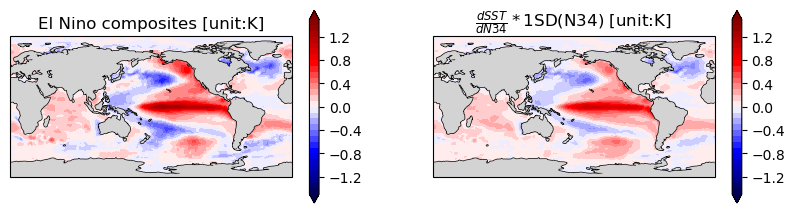

In [5]:
projection = ccrs.PlateCarree(central_longitude=180)
fig, axs   = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection': projection},figsize=(10,2.5))
axs        = axs.flatten()
cs = axs[0].contourf(lon, lat, np.mean(nino_comp.values,axis=0), cmap='seismic', 
                     levels=np.arange(-1.5,1.6,0.1), extend='both', transform=ccrs.PlateCarree()); 
axs[0].set_extent([0, 360, -90, 90], crs=ccrs.PlateCarree())
axs[0].add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)
axs[0].coastlines()
axs[0].set_title('El Nino composites [unit:K]')
plt.colorbar(cs);
cs = axs[1].contourf(lon, lat, r*np.nanstd(n34_run), cmap='seismic', 
                     levels=np.arange(-1.5,1.6,0.1), extend='both', transform=ccrs.PlateCarree()); 
axs[1].set_extent([0, 360, -90, 90], crs=ccrs.PlateCarree())
axs[1].add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)
axs[1].coastlines()
axs[1].set_title(r'$\frac{dSST}{dN34}*$1SD(N34) [unit:K]')
plt.colorbar(cs);